In [14]:
#import torch
#from torch import tensor

import numpy as np
from numpy import array
import networkx as nx
import pandas as pd

import io
import base64
from IPython.display import HTML
import matplotlib.pyplot as plt

In [15]:
# Some plotting functions

# older approach to plot
def draw_matrix(g2, bClose=False):
    n=g2.shape[0]
    plt.imshow(g2,)
    ax = plt.gca()
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticks(np.arange(-0.5, n-1), minor=True) 
    ax.set_yticks(np.arange(-0.5, n-1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=2)
    ax.tick_params(which='minor', bottom=False, left=False)
    #plt.tight_layout()
    if bClose:
        plt.close()
    return ax

# new more succint approach to plot
def draw_matrix2(g2, bClose=False):
    plt.pcolormesh(g2, edgecolors="gray")
    ax = plt.gca()
    ax.set_aspect("equal")
    ax.invert_yaxis()
    plt.tight_layout()
    if bClose:  # this is to stop the plot being displayed independently.
        plt.close()
    return ax

class FlowLayout(object):
    ''' A class / object to display plots in a horizontal / flow layout below a cell '''
    def __init__(self):
        # string buffer for the HTML: initially some CSS; images to be appended
        self.sHtml =  """
        <style>
        .floating-box {
        display: inline-block;
        margin: 10px;
        border: 3px solid #888888;  
        }
        </style>
        """

    def add_plot(self, oAxes):
        ''' Saves a PNG representation of a Matplotlib Axes object '''
        Bio=io.BytesIO() # bytes buffer for the plot
        fig = oAxes.get_figure()
        fig.canvas.print_png(Bio) # make a png of the plot in the buffer

        # encode the bytes as string using base 64 
        sB64Img = base64.b64encode(Bio.getvalue()).decode()
        self.sHtml+= (
            '<div class="floating-box">'+ 
            '<img src="data:image/png;base64,{}\n">'.format(sB64Img)+
            '</div>')

    def PassHtmlToCell(self):
        ''' Final step - display the accumulated HTML '''
        display(HTML(self.sHtml))

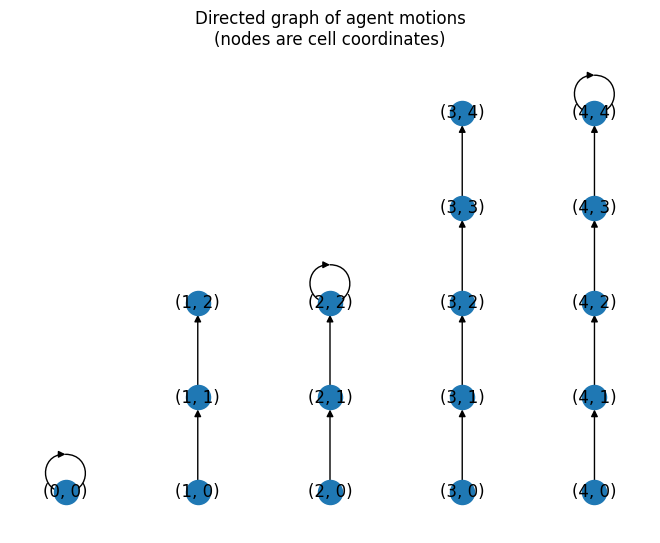

<Axes: >

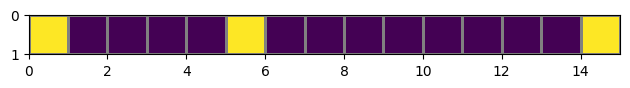

In [16]:
# create a directed graph of agent motions from cell to cell, ie (row, col) to (row, col)
# the agents are numbered from 1 to 10, and the cells are address by (row, col)
# the agents are arranged in chains, with the agents in each chain moving from left to right
G = nx.DiGraph()
G2 = nx.DiGraph()
iAg = 0
dAgRC = {} # dictionary of agent to row, col
dRCAg = {} # dictionary of row, col to agent
dRCRC = {} # dictionary of cell to axis coordinates
lAgColor = []

nChains = 5
nAg = nChains*(nChains+1)//2
vStops = np.zeros(nAg, dtype=int)

for iChain in range(nChains):
    iRow = iChain
    for iAg2 in range(iChain+1):
        
        iCol = iAg2

        rcFrom = (iRow, iCol)  # current position of the agent
        dAgRC[iAg] = rcFrom
        dRCAg[rcFrom] = iAg
        

        # if iChain is even, then the last agent in the chain is stopped        
        if (iChain % 2 == 0) and (iAg2 == iChain):
            rcTo = (iRow, iCol)  # self-loop, stopped agent
            G2.add_node(iAg)
            lAgColor.append('red')
            vStops[iAg] = 1
        else:
            rcTo = (iRow, iCol+1) # next cell to the right
            if iAg2 < iChain: # if not the last agent in the chain
                G2.add_edge(iAg, iAg+1)
            lAgColor.append('lightblue')
        
        # add the edge from rcFrom to rcTo, ie cell to cell
        G.add_edge(rcFrom, rcTo)

        iAg += 1

dRCRC = dict(zip(G.nodes(), G.nodes()))
        
nx.draw(G, with_labels=True, pos=dRCRC)
plt.title('Directed graph of agent motions\n(nodes are cell coordinates)')
plt.show()

draw_matrix2(vStops.reshape(1, -1))

#nx.draw_networkx_edge_labels(G)
#G.nodes()


Text(0.5, 1.0, 'Directed graph of agent linkages,\nwhere agents are adjacent (in chains)\nNodes are agents - la Guillaume Dalle / Robin Bochatay')

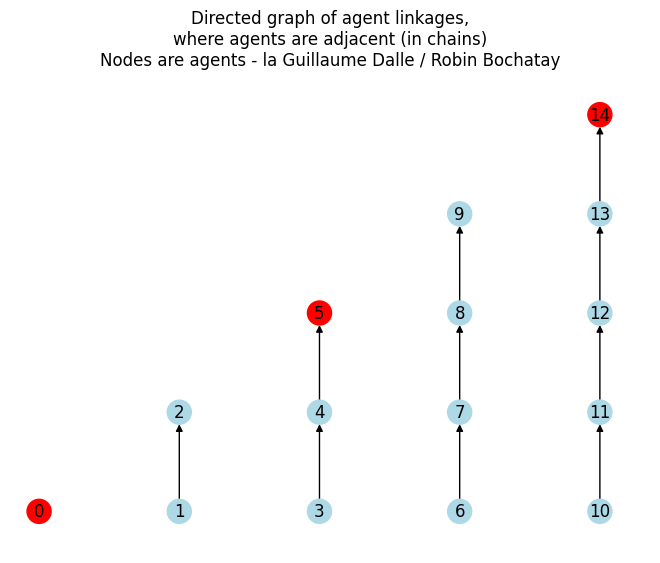

In [17]:
nx.draw(G2, with_labels=True, pos=dAgRC, node_color=lAgColor)
plt.title('Directed graph of agent linkages,\nwhere agents are adjacent (in chains)\nNodes are agents - la Guillaume Dalle / Robin Bochatay')

In [18]:
# each edge is the desired motion of an agent from one cell to the next in a single time step
# a stopped agent has a self-loop

#list(G.edges())


In [19]:
if False:
    # Create an ordinal index for the occupied cells
    dRCOrd = {}
    iOrd = 0
    for rc in G.nodes():
        dRCOrd[rc] = iOrd
        iOrd += 1

    # dRCOrd

In [20]:
if False:
    # Create the adjacency matrix of Movements 
    n = len(dRCOrd)
    g1 = np.zeros((n, n))
    vStops = np.zeros(n)
    # gStops = np.zeros((n,n))
    for rcFrom, rcTo in G.edges():
        iFrom = dRCOrd[rcFrom]
        iTo = dRCOrd[rcTo]

        if (iFrom == iTo):  # remove self-loops from the matrix
            vStops[iFrom] = 1 # but put them in the vector
            # gStops[iFrom, iTo] = 1 # and in the diagonal  stops matrix
            continue

        g1[iFrom, iTo] = 1

    oFL = FlowLayout()

    ax = draw_matrix(g1,)
    plt.title("Adjacency matrix, self loops removed")
    plt.close()
    oFL.add_plot(ax)
    oFL.PassHtmlToCell()

(15, 15)

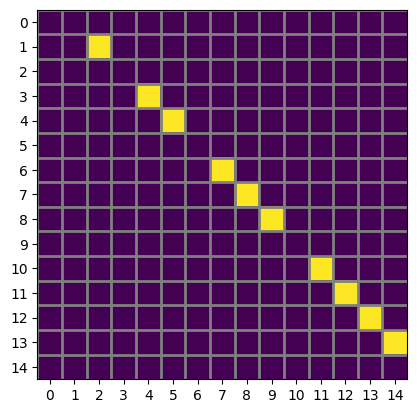

In [21]:
g2Adj = nx.to_numpy_array(G2) # get adjacency matrix of G2
n = g2Adj.shape[0]
draw_matrix(g2Adj)
g2Adj.shape


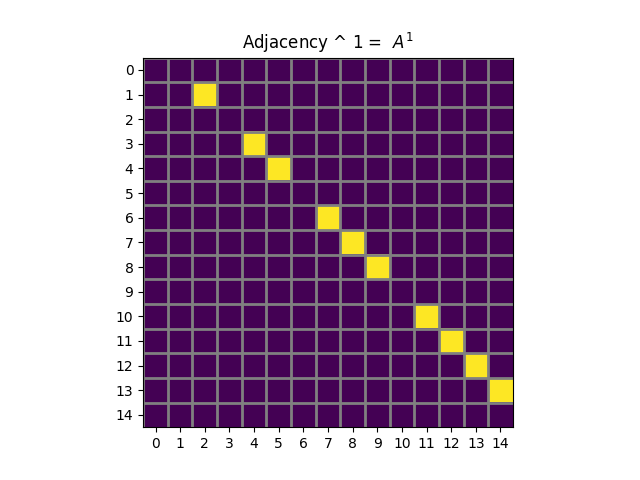
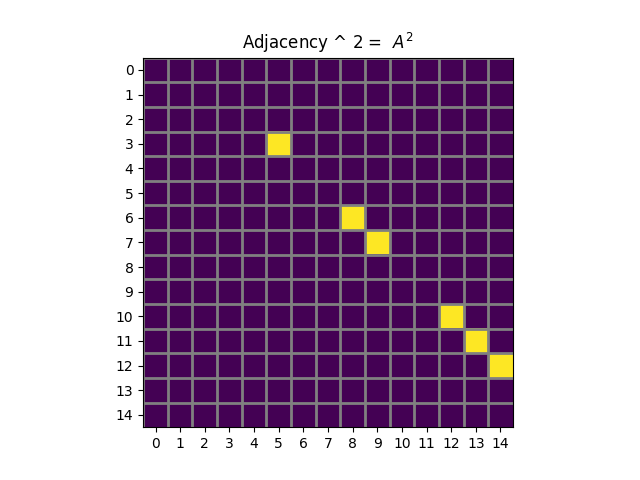
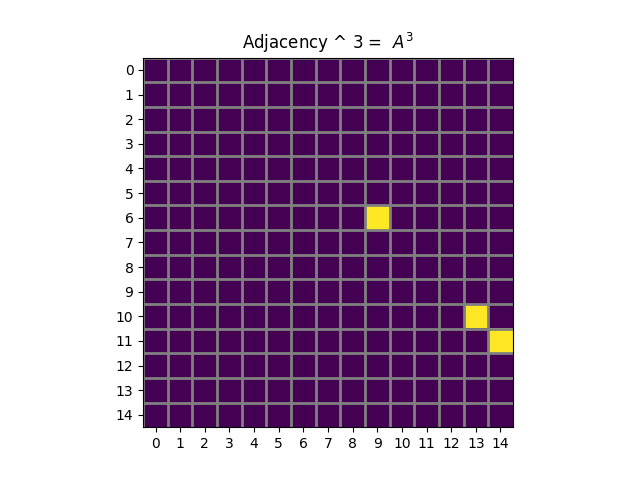
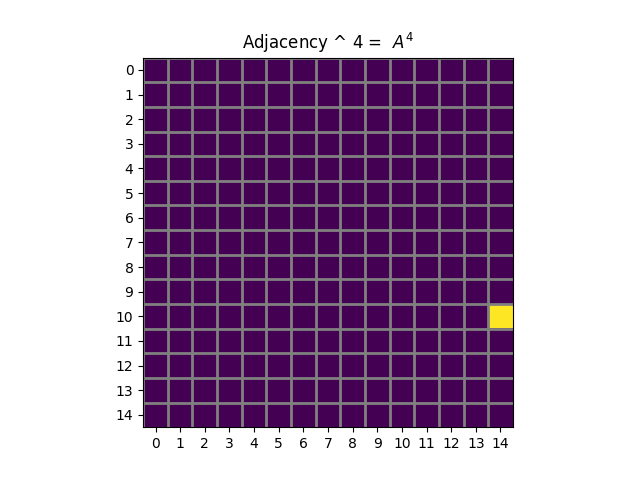
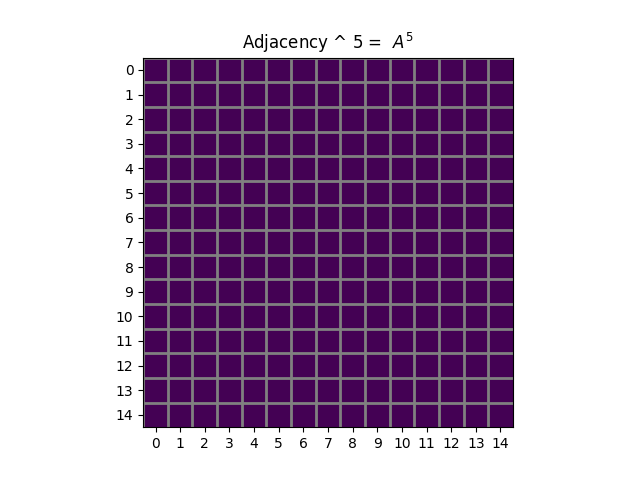
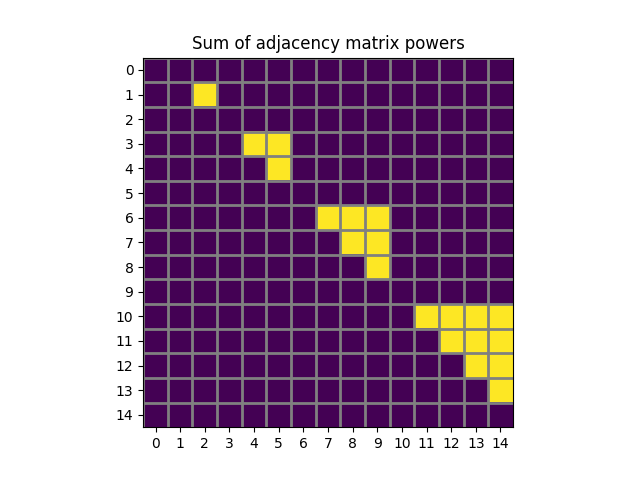

In [22]:
nPowers = 5
g3Powers = np.zeros((n,n, nPowers))  # 3-tensor / cube of adjacency matrix powers
oFL = FlowLayout()
for iPower in range(nPowers):
    g3Powers[:,:,iPower] = np.linalg.matrix_power(g2Adj, iPower+1)
    draw_matrix(g3Powers[:,:,iPower], bClose=False)
    plt.title(f"Adjacency ^ {iPower+1} =  $A^{iPower+1}$")
    oFL.add_plot(plt.gca())
    plt.close()

g2SumPowers = np.sum(g3Powers, axis=2)
draw_matrix(g2SumPowers)
plt.title("Sum of adjacency matrix powers")
oFL.add_plot(plt.gca())
plt.close()
oFL.PassHtmlToCell()

In [23]:
g2SumPowers

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0.

In [24]:
# Now the blocked agents can be calculated as the product of
# the sum of powers x the vector of stopped agents
vBlocked = g2SumPowers @ vStops

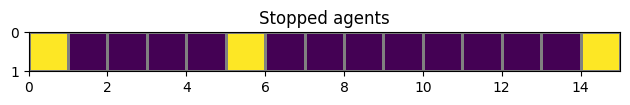

Text(0.5, 1.0, 'Blocked agents')

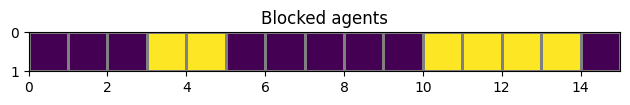

In [25]:
draw_matrix2(vStops.reshape(1, -1))
plt.title("Stopped agents")
plt.show()
draw_matrix2(vBlocked.reshape(1, -1))
plt.title("Blocked agents")

## Some timings

(100, 100)
CPU times: user 495 μs, sys: 65 μs, total: 560 μs
Wall time: 563 μs
CPU times: user 4.33 ms, sys: 0 ns, total: 4.33 ms
Wall time: 4.33 ms


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

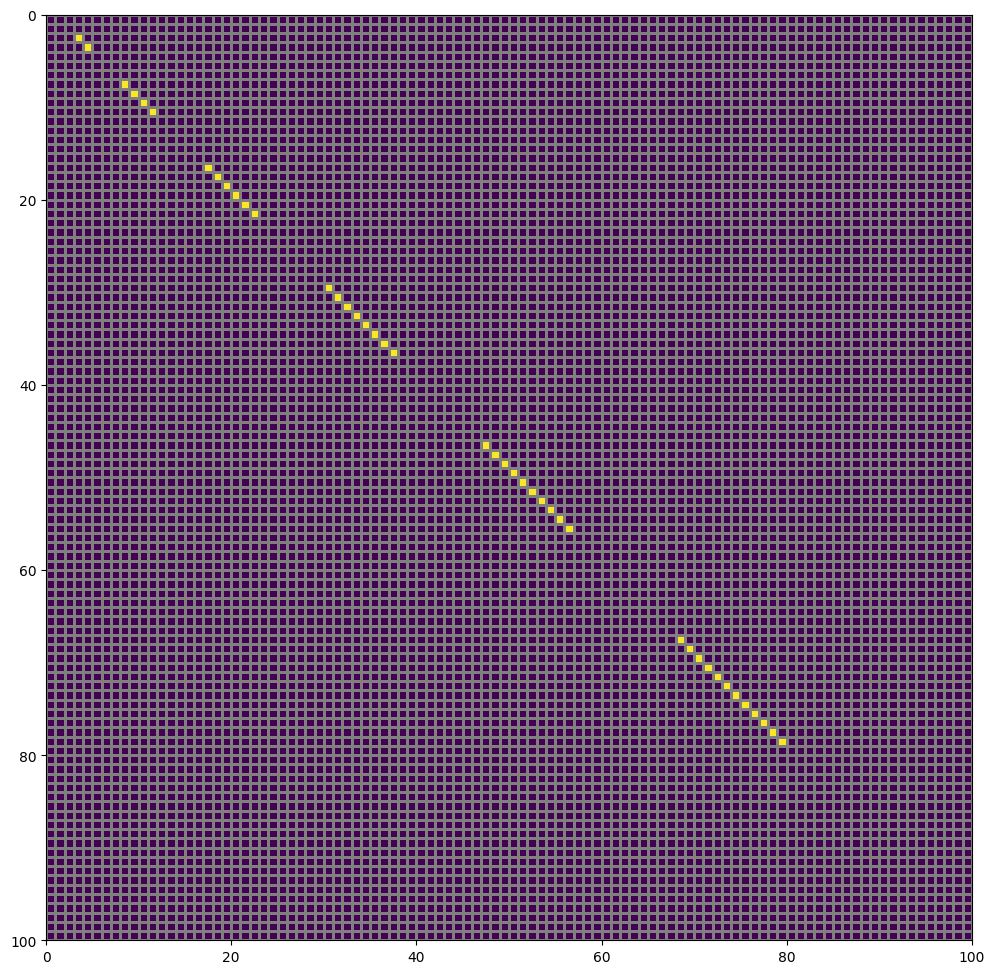

In [109]:
m=100
nChains = 13
B = np.zeros((m,m), dtype=int)
iAg = 0

for iChain in range(nChains):
    iRow = iChain
    for iAg2 in range(iChain):
        iAg += 1
        if iChain % 2 == 0:
            B[iAg, iAg+1] = 1
        else:
            id 
        
print(B.shape)
plt.figure(figsize=(10,10))
draw_matrix2(B)

%time np.linalg.matrix_power(B, 2)
%time np.linalg.matrix_power(B, 100)


In [122]:
def fNumpyPowerSum(gB, nPower):
    gC = np.zeros_like(gB)
    gBi = gB.copy()
    
    for iPower in range(nPower-1):
        gBi = gBi @ gB
        gC += gBi
        if gBi.sum() == 0:
            #print(f"zero at power {iPower}")
            break
    

In [123]:
%timeit fNumpyPowerSum(B, 100)

6.49 ms ± 12.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
from torch import tensor
import torch

import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION', )
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())


bCuda = torch.cuda.is_available()
if bCuda:
  dev = "cuda:0" 
else:  
  dev = "cpu" 
oTDev = torch.device(dev)
print(oTDev)

print(torch.cuda.get_device_properties(0))


__Python VERSION: 3.12.5 | packaged by Anaconda, Inc. | (main, Sep 12 2024, 18:27:27) [GCC 11.2.0]
__pyTorch VERSION: 2.4.1
__CUDA VERSION
/bin/bash: line 1: nvcc: command not found
__CUDNN VERSION: 90100
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0
cuda:0
_CudaDeviceProperties(name='NVIDIA GeForce GTX 1070', major=6, minor=1, total_memory=8110MB, multi_processor_count=15)


In [43]:
torch.cuda.set_device(0)
torch.cuda.current_device()

0

In [124]:
tB = tensor(B, dtype=float).to(oTDev)
print(tB.shape, tB.device, tB.dtype)
%timeit torch.linalg.matrix_power(tB, 100)

torch.Size([100, 100]) cuda:0 torch.float64
179 μs ± 4.54 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [125]:
%time torch.linalg.matrix_power(tB, 100)
%time torch.linalg.matrix_power(tB, 100)
%time torch.linalg.matrix_power(tB, 100)

CPU times: user 0 ns, sys: 764 μs, total: 764 μs
Wall time: 505 μs
CPU times: user 0 ns, sys: 264 μs, total: 264 μs
Wall time: 165 μs
CPU times: user 0 ns, sys: 55 μs, total: 55 μs
Wall time: 57.7 μs


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', dtype=torch.float64)

In [130]:
def fTensorPowerSum(tB, nPower):
    tC = torch.zeros_like(tB).to(oTDev)
    tBi = tB.clone()
    
    for iPower in range(nPower-1):
        tBi = tBi @ tB
        tC += tBi
        if tBi.sum() == 0:
            #print(f"zero at power {iPower}")
            break
    # print(f"Devices: tB: {tB.device}, tC: {tC.device}, tBi:{tBi.device}")
    

In [131]:
%timeit fTensorPowerSum(tB, 100)
# %time fMatrixPower(tB, 100)

587 μs ± 3.96 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [54]:
tC = tB.to(oTDev)

In [58]:
tB.device, tC.device

(device(type='cpu'), device(type='cuda', index=0))

In [61]:
%time fMatrixPower(tC, 100)

RuntimeError: "addmm_cuda" not implemented for 'Long'